# Predict RTSI index with Random Forest models

# Read and prepare

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import numpy as np
from pprint import pprint
#plt.style.use('seaborn')


## Read data

                        open     high      low    close      vol
datetime                                                        
2018-01-03 10:00:00  1156.44  1160.61  1156.28  1160.46  9175259
2018-01-03 10:05:00  1160.48  1162.36  1159.97  1160.41  3997514
2018-01-03 10:10:00  1163.29  1164.22  1163.15  1164.22  5464189
2018-01-03 10:15:00  1164.51  1165.31  1164.38  1164.72  3112672
2018-01-03 10:20:00  1164.72  1164.76  1163.23  1163.61  3283276


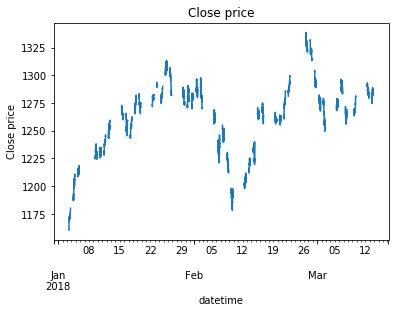

In [2]:
# Read 1M OHLCV data from file instead of pdr.DataReader('RTSI','moex',start,end) because moex network source doesn't allow often downloads
df=pd.read_csv("/home/dima/projects/stock-predictor/data/RI.RTSI_180101_180313.csv", 
               parse_dates={'datetime':[2,3]}, 
               index_col='datetime')
#df=df.loc['2018-01-09']
df=df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df.columns=['open','high','low','close','vol']
# Resample 1Min OHLC to 5Min OHLC
df=df.resample('5Min').agg({
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last',
        'vol': 'sum'})
print(df.head())
df['close'].plot(title = 'Close price')
plt.ylabel('Close price')
plt.show()

## Prepare data

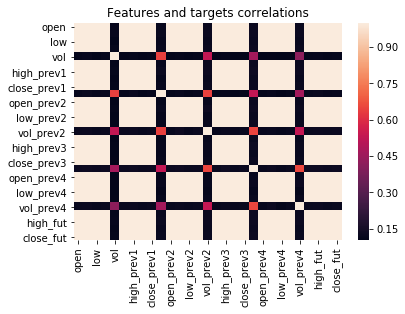

In [3]:
#lag = 5
# Fill in future values
target_names = ['open_fut', 'high_fut', 'low_fut', 'close_fut']
df['open_fut'] = df['open'].shift(-1)
df['high_fut'] = df['high'].shift(-1)
df['low_fut'] = df['low'].shift(-1)
df['close_fut'] = df['close'].shift(-1)

# Fill in prev values
prev_depth=5
feature_names=['open', 'high', 'low', 'close', 'vol']
for i in range(1,prev_depth):
    for name in ['open', 'high', 'low', 'close', 'vol']:
        prev_name = name+'_prev'+str(i)
        feature_names.append(prev_name)
        df[prev_name] = df[name].shift(i)
df = df.dropna()
features=df[feature_names]
targets = df[target_names]
sns.heatmap(df.loc[:,feature_names + target_names].corr())
plt.title('Features and targets correlations')
plt.rcParams["figure.figsize"]=[10,10]
plt.show()
train_X, test_X, train_y, test_y = train_test_split(features, targets, shuffle=False)



# Random Forest 
## Random Forest Regressor model 

In [4]:
test_scores=[]
grid = ParameterGrid({'n_estimators': [200], 'max_depth':[6], 'max_features':[23,len(feature_names)]})

# Hyperparameter tuning
rfr = RandomForestRegressor()
for g in grid:
    print(g)
    rfr.set_params(**g)
    rfr.fit(train_X, train_y)
    train_score=rfr.score(train_X, train_y)
    test_score=rfr.score(test_X,test_y)
    print('Hyperparameters: %s; train score: %s; test score: %s' % (g, train_score, test_score))
    test_scores.append(test_score)

# Get the best hyperparams combination
best_idx=np.argmax(test_scores)
g=grid[best_idx]
print('Best hyperparameters: %s' % g)

rfr.set_params(**g)
rfr.fit(train_X, train_y)
y = rfr.predict(test_X)
print('Train score: %s' % rfr.score(train_X, train_y))
print('Test score: %s' % rfr.score(test_X, test_y))


{'max_depth': 6, 'max_features': 23, 'n_estimators': 200}
Hyperparameters: {'max_depth': 6, 'max_features': 23, 'n_estimators': 200}; train score: 0.9994781474397294; test score: 0.9166103641285971
{'max_depth': 6, 'max_features': 25, 'n_estimators': 200}
Hyperparameters: {'max_depth': 6, 'max_features': 25, 'n_estimators': 200}; train score: 0.9994799587635607; test score: 0.9169841587624709
Best hyperparameters: {'n_estimators': 200, 'max_features': 25, 'max_depth': 6}
Train score: 0.9994778837986154
Test score: 0.9172220029246317


### Random Forest Regressor prediction EDA <a name="rfr prediction eda"/>

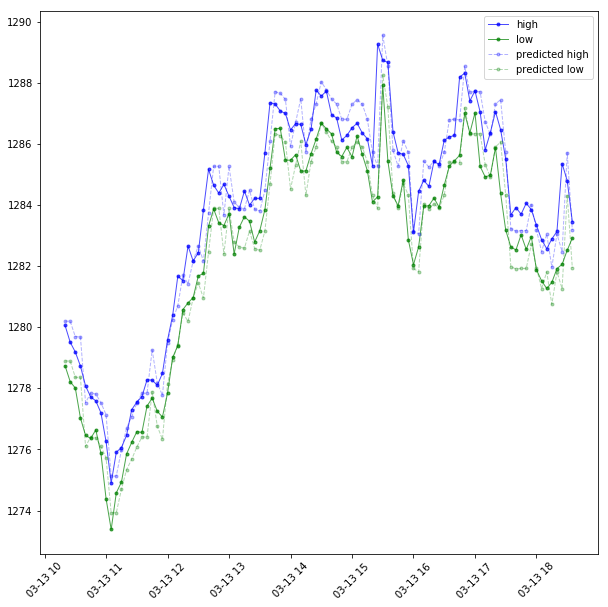

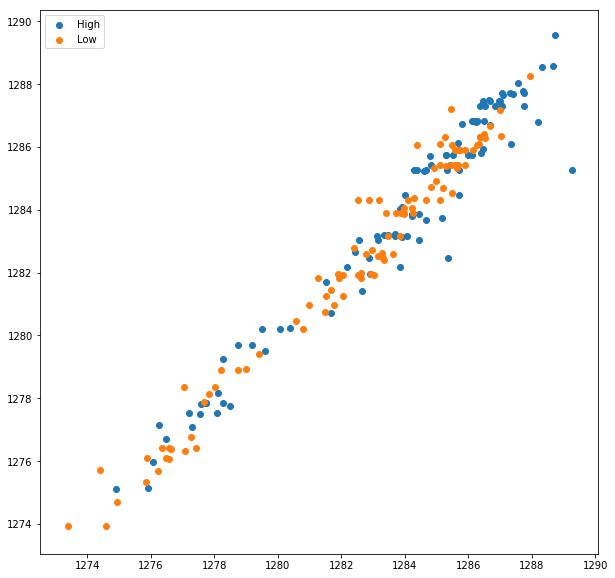

In [5]:
last_points = 100
original = test_y[['high_fut', 'low_fut']][-last_points:]
original.columns=['high', 'low']
predicted = pd.DataFrame(y.reshape(test_y.shape), columns=target_names, index = test_y.index, )[['high_fut', 'low_fut']][-last_points:]
predicted.columns=['high', 'low']

# Price real and predicted plot
plt.plot(original['high'], marker='.', linestyle='solid', color='b', alpha=0.7, linewidth=1)
plt.plot(original['low'], marker='.', linestyle='solid', color='green', alpha=0.7, linewidth=1)
plt.plot(predicted['high'], marker='.', linestyle='dashed', color='b', alpha=0.3, linewidth=1)
plt.plot(predicted['low'], marker='.', linestyle='dashed', color='green', alpha=0.3, linewidth=1)
plt.legend(['high','low','predicted high','predicted low'])
plt.xticks(rotation=45)
#plt.title='Predicted vs real'
plt.xlabel='Time'
plt.ylabel='Price'
plt.show()

#plt.rcParams["figure.figsize"] = [16,9]

#f, (ax1, ax2) = plt.subplots(1,2)

# High scatterplot
#ax1.scatter(x=original['high'], y=predicted['high'])
#ax1.xlabel='real price'
#ax1.ylabel='predicted price'
#ax1.set_title('High scatterplot')

# Low scatterplot
#ax2.scatter(x=original['low'], y=predicted['low'])
#ax2.xlabel='real price' 
#ax2.ylabel='predicted price'
#ax2.set_title('Low scatterplot')
#plt.show()
#plt.plot([0,0],[1000,1000])

plt.scatter(x=original['high'], y=predicted['high'])
plt.scatter(x=original['low'], y=predicted['low'])
#plt.plot(x=[1000,2000],y=[1000,2000])
plt.legend(['High', 'Low'])
plt.xlabel='Real price'
plt.ylabel='Predicted price'
#plt.title("Real vs predicted scatterplot")
plt.show()


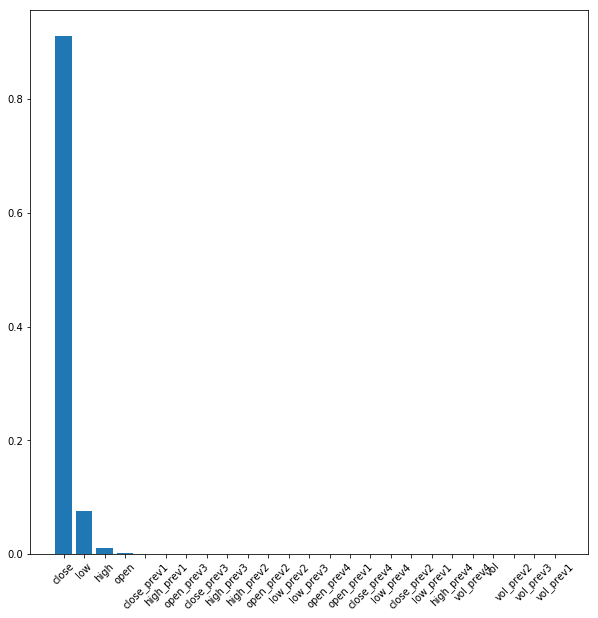

In [6]:

# Analyze feature importances
imp = rfr.feature_importances_
sorted_idx=np.argsort(imp)[::-1]
sorted_labels = np.array(train_X.columns[sorted_idx])

plt.bar(sorted_labels, imp[sorted_idx])
plt.title='Feature importances'
plt.ylabel='Importance'
plt.xticks(rotation=45)

plt.show()

## Gradient boosting model

In [44]:
gbr = GradientBoostingRegressor(max_features=25,learning_rate=0.05, n_estimators=200, subsample=0.8, random_state=42)
mor = MultiOutputRegressor(gbr, n_jobs=-1).fit(train_X, train_y)
mor.score(test_X, test_y)
y=mor.predict(test_X)
print('Train score: %s' % mor.score(train_X, train_y))
print('Test score: %s' % mor.score(test_X, test_y))

Train score: 0.999619825230542
Test score: 0.9227113570851232


## Gradient boosting predictions EDA

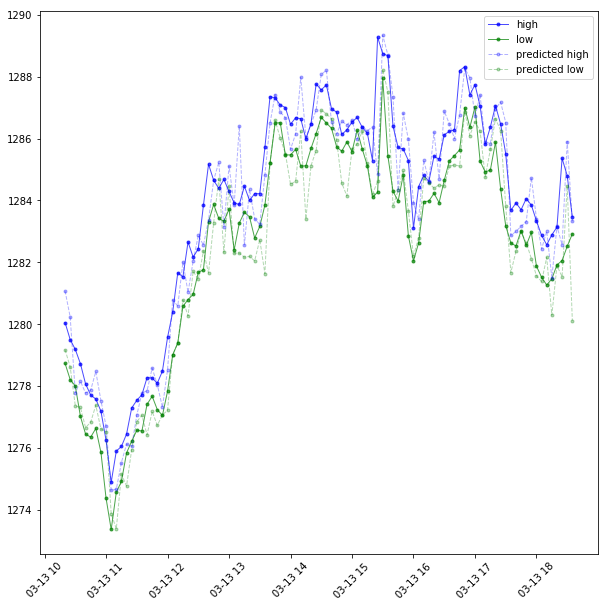

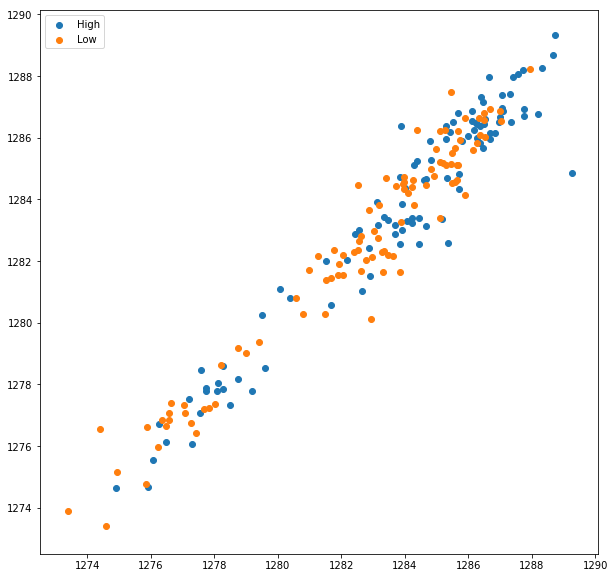

In [24]:
last_points = 100
original = test_y[['high_fut', 'low_fut']][-last_points:]
original.columns=['high', 'low']
predicted = pd.DataFrame(y.reshape(test_y.shape), columns=target_names, index = test_y.index, )[['high_fut', 'low_fut']][-last_points:]
predicted.columns=['high', 'low']

# Price real and predicted plot
plt.plot(original['high'], marker='.', linestyle='solid', color='b', alpha=0.7, linewidth=1)
plt.plot(original['low'], marker='.', linestyle='solid', color='green', alpha=0.7, linewidth=1)
plt.plot(predicted['high'], marker='.', linestyle='dashed', color='b', alpha=0.3, linewidth=1)
plt.plot(predicted['low'], marker='.', linestyle='dashed', color='green', alpha=0.3, linewidth=1)
plt.legend(['high','low','predicted high','predicted low'])
plt.xticks(rotation=45)
#plt.title='Predicted vs real'
plt.xlabel='Time'
plt.ylabel='Price'
plt.show()

#plt.rcParams["figure.figsize"] = [16,9]

#f, (ax1, ax2) = plt.subplots(1,2)

# High scatterplot
#ax1.scatter(x=original['high'], y=predicted['high'])
#ax1.xlabel='real price'
#ax1.ylabel='predicted price'
#ax1.set_title('High scatterplot')

# Low scatterplot
#ax2.scatter(x=original['low'], y=predicted['low'])
#ax2.xlabel='real price' 
#ax2.ylabel='predicted price'
#ax2.set_title('Low scatterplot')
#plt.show()
#plt.plot([0,0],[1000,1000])

plt.scatter(x=original['high'], y=predicted['high'])
plt.scatter(x=original['low'], y=predicted['low'])
#plt.plot(x=[1000,2000],y=[1000,2000])
plt.legend(['High', 'Low'])
plt.xlabel='Real price'
plt.ylabel='Predicted price'
#plt.title("Real vs predicted scatterplot")
plt.show()